1. Import libraries

In [1]:
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

2. Setup configuration

In [2]:
RANDOM_STATE = 42
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (7,5)

3. Paths

In [3]:
DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models"); MODEL_DIR.mkdir(exist_ok=True)

DF_PATH = DATA_DIR / "model_strict.csv" 

4. Load Data

In [4]:
df = pd.read_csv(DF_PATH)
print(DF_PATH.name, df.shape)
display(df.head(3))

model_strict.csv (3067, 37)


,imdb_score,imdb_votes,imdb_votes_log1p,runtime,duration_minutes,release_year,desc_len,num_genres,is_show,is_classic,...,ctry_India,ctry_Japan,ctry_Nigeria,ctry_Other,ctry_Philippines,ctry_South Korea,ctry_Spain,ctry_United Kingdom,ctry_United States,ctry_Unknown
0,8.2,530877.0,13.182288,91,92,1975,415,3,0,1,...,False,False,False,False,False,False,False,True,False,False
1,7.8,94121.0,11.452347,170,173,1964,121,2,0,1,...,False,False,False,False,False,False,False,False,True,False
2,5.8,69053.0,11.142644,104,105,1980,347,2,0,1,...,False,False,False,False,False,False,False,False,True,False


5. Build classification target (high vs not-high)

In [5]:
THRESH = 7.0
df["is_high"] = (df["imdb_score"] >= THRESH).astype(int)
df["is_high"].value_counts(normalize=True).rename("class_balance (%)")\
    .mul(100).round(2).to_frame()

,class_balance (%)
is_high,
0,64.53
1,35.47


6. Features: drop non-features & target

In [6]:
drop_cols = {"title","id","imdb_id","description","imdb_score"} & set(df.columns)
feature_df = df.drop(columns=list(drop_cols))
y = df["is_high"].astype(int)
X = feature_df.drop(columns=["is_high"])

In [7]:
# Identify dtypes
num_cols = X.select_dtypes(include=["int64","float64","int32","float32","Int64","Float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","string","category","bool","boolean","UInt8","Int8"]).columns.tolist()
# If both runtime and duration_minutes exist, prefer duration_minutes
if "duration_minutes" in num_cols and "runtime" in num_cols:
    X = X.drop(columns=["runtime"])
    num_cols.remove("runtime")

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['imdb_votes', 'imdb_votes_log1p', 'duration_minutes', 'release_year', 'desc_len', 'num_genres', 'is_show', 'is_classic']
Categorical: ['type', 'age_G', 'age_Other', 'age_PG', 'age_PG-13', 'age_R', 'age_TV-14', 'age_TV-G', 'age_TV-MA', 'age_TV-PG', 'age_TV-Y', 'age_TV-Y7', 'age_Unknown', 'ctry_Canada', 'ctry_France', 'ctry_India', 'ctry_Japan', 'ctry_Nigeria', 'ctry_Other', 'ctry_Philippines', 'ctry_South Korea', 'ctry_Spain', 'ctry_United Kingdom', 'ctry_United States', 'ctry_Unknown']


7. Split (70/15/15)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)
print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Train: (2146, 33) Valid: (460, 33) Test: (461, 33)


8. Preprocess & baselines

In [9]:
num_tf = Pipeline([("scaler", StandardScaler())])
cat_tf = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocess = ColumnTransformer(
    [("num", num_tf, num_cols), ("cat", cat_tf, cat_cols)],
    remainder="drop"
)

models = {
    "LogReg(L2)": LogisticRegression(
        penalty="l2", solver="liblinear", max_iter=200, random_state=RANDOM_STATE
    ),
    "RF(200)": RandomForestClassifier(
        n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1
    ),
}

def evaluate_cls(pipe, X, y):
    p = pipe.predict_proba(X)[:,1]
    yhat = (p >= 0.5).astype(int)
    return {
        "Accuracy": accuracy_score(y, yhat),
        "Precision": precision_score(y, yhat, zero_division=0),
        "Recall": recall_score(y, yhat, zero_division=0),
        "F1": f1_score(y, yhat, zero_division=0),
        "ROC_AUC": roc_auc_score(y, p),
    }

val_rows = []
fitted = {}
for name, est in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", est)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe
    metrics = evaluate_cls(pipe, X_valid, y_valid)
    val_rows.append({"Model": name, **{k: round(v,3) for k,v in metrics.items()}})
pd.DataFrame(val_rows).sort_values("ROC_AUC", ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,RF(200),0.726,0.648,0.497,0.562,0.723
0,LogReg(L2),0.685,0.596,0.344,0.436,0.683


9. Hyperparameter search on the best baseline (Random Forest)

In [10]:
rf_pipe = Pipeline([("prep", preprocess), ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
param_dist = {
    "model__n_estimators": [300,500,800,1000],
    "model__max_depth": [None, 12, 20, 30, 50],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [0.5, "sqrt", "log2", None],
    "model__class_weight": [None, "balanced"]
}
search = RandomizedSearchCV(
    rf_pipe, param_distributions=param_dist,
    n_iter=40, scoring="roc_auc", cv=5, n_jobs=-1,
    random_state=RANDOM_STATE, verbose=1
)
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best params:", search.best_params_)

best_val = evaluate_cls(best_rf, X_valid, y_valid)
print("Tuned RF — Valid:", {k: round(v,3) for k,v in best_val.items()})

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__class_weight': None}
Tuned RF — Valid: {'Accuracy': 0.726, 'Precision': 0.68, 'Recall': 0.429, 'F1': 0.526, 'ROC_AUC': 0.744}


10. Retrain on Train+Valid aqnd evaluate once on Test

In [11]:
X_trv = pd.concat([X_train, X_valid]); y_trv = pd.concat([y_train, y_valid])
best_rf.fit(X_trv, y_trv)
test_metrics = evaluate_cls(best_rf, X_test, y_test)
print("Final Test — Tuned RF:", {k: round(v,3) for k,v in test_metrics.items()})

Final Test — Tuned RF: {'Accuracy': 0.753, 'Precision': 0.778, 'Recall': 0.427, 'F1': 0.551, 'ROC_AUC': 0.79}


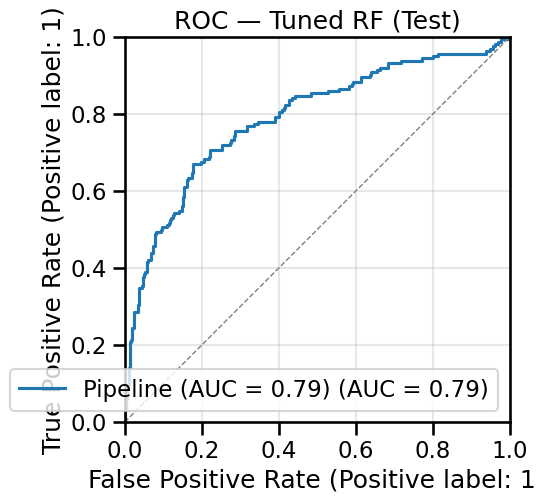

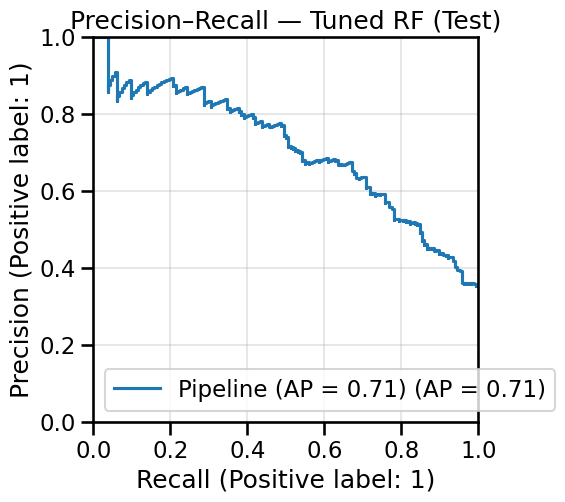

In [16]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Use your tuned RF pipeline here
# If your variable is different (e.g., tuned_rf_pipe or best_rf), this line will pick it up.
best_clf = (globals().get("best_clf")
            or globals().get("best_rf")
            or globals().get("tuned_rf_pipe")
            or globals().get("best_pipe")
            or rf_cv.best_estimator_)

y_proba = best_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
ap  = average_precision_score(y_test, y_proba)

# ROC
fig, ax = plt.subplots(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba,
                                 name=f"Pipeline (AUC = {auc:.2f})",
                                 ax=ax)
ax.plot([0,1],[0,1],'--', lw=1, color='grey')
ax.grid(alpha=0.3)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title("ROC — Tuned RF (Test)")
plt.show()

# PR
fig, ax = plt.subplots(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba,
                                        name=f"Pipeline (AP = {ap:.2f})",
                                        ax=ax)
ax.grid(alpha=0.3)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title("Precision–Recall — Tuned RF (Test)")
plt.show()

11. Permutation importance (validation)

,feature,perm_importance_mean,perm_importance_std
2,num__duration_minutes,0.077842,0.011804
1,num__imdb_votes_log1p,0.070087,0.012806
3,num__release_year,0.063944,0.004923
0,num__imdb_votes,0.061151,0.011145
4,num__desc_len,0.044333,0.005630
5,num__num_genres,0.035473,0.004567
33,cat__age_Unknown_True,0.014208,0.002242
32,cat__age_Unknown_False,0.014131,0.002360
55,cat__ctry_United States_True,0.009281,0.001663
45,cat__ctry_Other_True,0.008851,0.000985


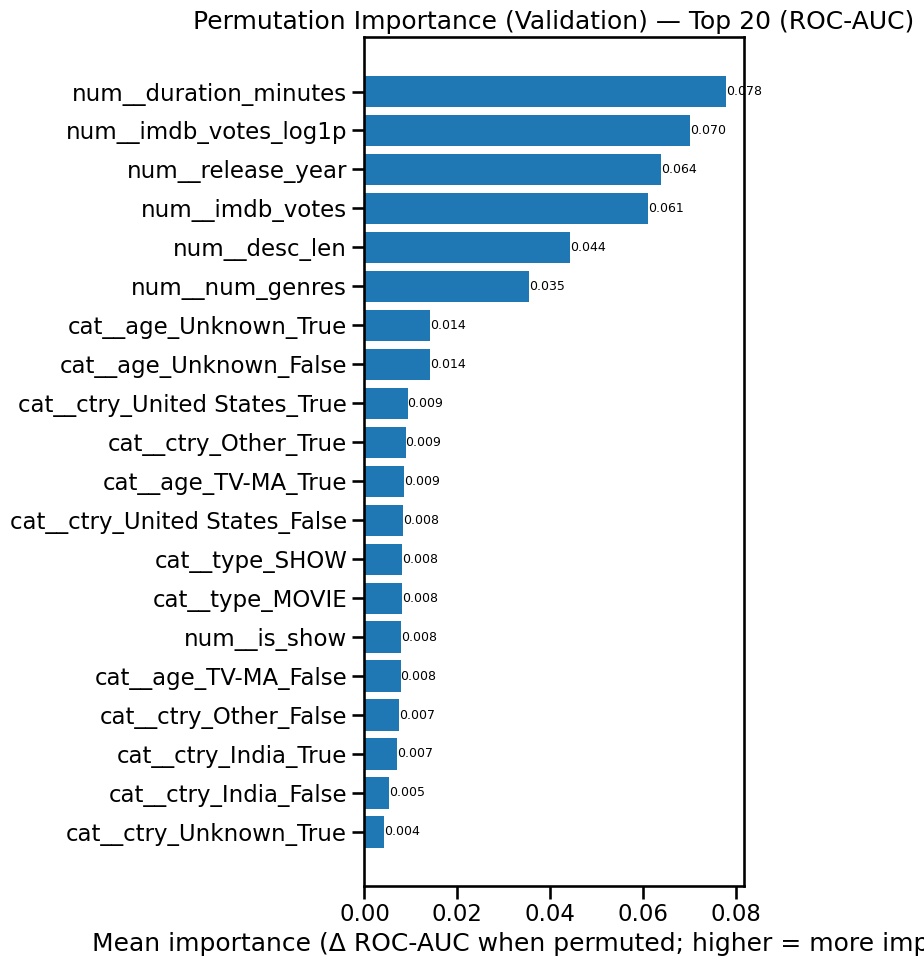

In [17]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Grab tuned pipeline again (same logic as above)
best_clf = (globals().get("best_clf")
            or globals().get("best_rf")
            or globals().get("tuned_rf_pipe")
            or globals().get("best_pipe")
            or rf_cv.best_estimator_)

# 1) Transform validation set once with the preprocessor
prep = best_clf.named_steps["prep"]
model = best_clf.named_steps["model"]

Xv_trans = prep.transform(X_valid)

# 2) Feature names coming out of the ColumnTransformer
try:
    feat_names = prep.get_feature_names_out()
except Exception:
    feat_names = np.array([f"f{i}" for i in range(Xv_trans.shape[1])])

# 3) Permutation importance on the model (data already transformed)
perm = permutation_importance(
    model,
    Xv_trans, y_valid,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc",
    n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": feat_names,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False)

display(imp_df.head(30))

# 4) Nice Top-20 plot with labels
top_k = 20
top = imp_df.head(top_k).iloc[::-1]  # reverse for horizontal bars

plt.figure(figsize=(8, 10))
plt.barh(top["feature"], top["perm_importance_mean"])
for i, v in enumerate(top["perm_importance_mean"]):
    plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)
plt.title("Permutation Importance (Validation) — Top 20 (ROC-AUC)")
plt.xlabel("Mean importance (Δ ROC-AUC when permuted; higher = more important)")
plt.tight_layout()
plt.show()

12. Save best classifier + metrics

In [19]:
import joblib
out_path = MODEL_DIR / "clf_randomforest_tuned.joblib"
joblib.dump(best_rf, out_path)
with open(MODEL_DIR / "clf_metrics_test.json","w") as f:
    json.dump({k: float(v) for k,v in test_metrics.items()}, f, indent=2)
print(f"[ok] Saved classifier → {out_path}")

[ok] Saved classifier → ../models/clf_randomforest_tuned.joblib


13. Key insights - Classification (High vs Not-High IMDb Score)

Model Performance (Test set, Tuned RandomForest):

	•	ROC-AUC: 0.79 → good separation between high and not-high titles.
	•	Accuracy: 75.3%
	•	Precision: 77.8% (when it predicts “High”, it’s correct most of the time).
	•	Recall: 42.7% (misses some high-scoring titles).
	•	F1 Score: 0.55 → balanced but recall-limited performance.
	•	PR-AUC: 0.71 → robust precision-recall trade-off despite class imbalance (only 35% “High”).

ROC Curve: 

	Shows strong lift over random guessing; the model maintains good true positive rates at low false positive rates.

Precision-Recall Curve: 

	Precision stays high (>0.8) up to moderate recall, then drops as recall increases.

Permutation Importance (Validation, ROC-AUC metric):

	1.	Duration (minutes) — most influential numeric predictor for “High” classification.
	2.	IMDb votes (log and raw) — strong indicators of popularity correlating with higher ratings.
	3.	Release year — newer or certain eras have stronger likelihoods for high scores.
	4.	Description length — longer descriptions slightly linked to higher ratings.
	5.	Number of genres — modest effect; too many genres can dilute focus.
	6.	Type (SHOW vs MOVIE) — small but measurable lift; shows have slightly higher odds.
	7.	Country & age rating signals — individually weak, but collectively contribute to subtle classification nuances.

Overall Takeaways:

	•	The tuned RandomForest provides a balanced high-precision classifier for predicting high-rating titles, though recall is moderate.
	•	Popularity (votes), content length (duration, description), and recency (release year) are the primary drivers.
	•	Metadata like type, country, and age rating matter less but help refine predictions.